<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{lit_colab_boris} -->

# Fine-tune GPT-3 with Weights & Biases

OpenAI’s API gives practitioners access to GPT-3, an incredibly powerful natural language model that can be applied to virtually any task that involves understanding or generating natural language.

If you use OpenAI's API to [fine-tune GPT-3](https://beta.openai.com/docs/guides/fine-tuning), you can now use the W&B integration to track experiments, models, and datasets in your central dashboard.

All it takes is one line: `openai wandb sync`

## Set up your API key

In [ ]:
# Enter credentials
%env OPENAI_API_KEY=***

**WARNING: Remove the API key after running the cell and clear output so it does not get logged to wandb in case you sync code (see settings)**

## Install dependencies

In [ ]:
!pip install --upgrade openai wandb

**You may see a warning to restart runtime. If so, restart it.**

## Optional: Fine-tune GPT-3

It's always more fun to experiment with your own projects so if you have already used the openai API to fine-tune GPT-3, just [skip this section](#scrollTo=YDAlohFGAc_g)!

Otherwise let's fine-tune GPT-3 on Wikipedia!

### Imports and initial set-up

In [ ]:
import openai
import wandb
from pathlib import Path
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

### Dataset Preparation

We created a dataset from [Wikipedia-based Image Text (WIT) Dataset](https://github.com/google-research-datasets/wit):
* only english items
* prompt: title of the page
* completion: first sentence of page description

The dataset was logged to W&B and can be explored at [`borisd13/GPT-3/wiki-dataset`](https://wandb.ai/borisd13/GPT-3/artifacts/dataset/wiki-dataset/6c56b60c26dc155076f5/files/wiki_title_description.table.json).

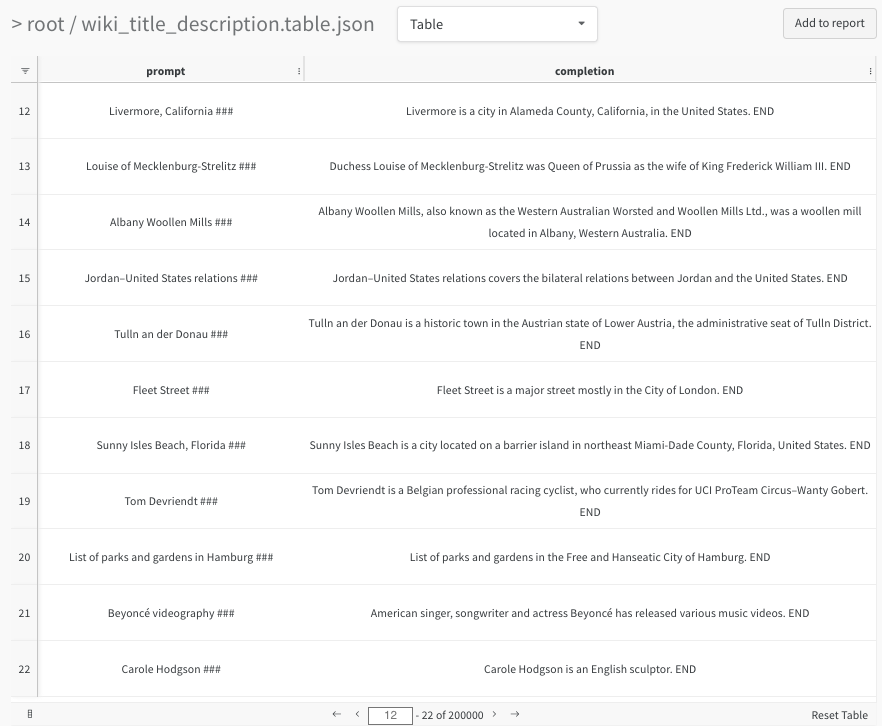

We now split it into training/validation dataset.

In [ ]:
# create a job for splitting dataset
run = wandb.init(project='GPT-3', job_type='split dataset')

In [ ]:
# download full dataset
artifact = run.use_artifact('borisd13/GPT-3/wiki-dataset:latest', type='dataset')
dataset_path = artifact.get_path('wiki_title_description.jsonl').download()
dataset_path

A copy of our dataset is now cached locally.

Let's look at a few samples.

In [ ]:
!head $dataset_path

We can verify that the data is correctly formatted with openai client.

In [ ]:
!openai tools fine_tunes.prepare_data -f $dataset_path

In [ ]:
# check number of samples
!wc -l $dataset_path

The file is very large (1.5M samples). For this demo, we'll extract:
* training set: 50k top samples
* validation set: 10k bottom samples

In [ ]:
n_train = 50_000
n_valid = 10_000

In [ ]:
wandb.config.update({'n_train': n_train,
                     'n_valid': n_valid})

In [ ]:
!head -n $n_train $dataset_path > wiki_train.jsonl
!tail -n $n_valid $dataset_path > wiki_valid.jsonl

Let's log our train/valid split as W&B artifact.

In [ ]:
# Create tables for better visualization (optional)
df_train = pd.read_json('wiki_train.jsonl', orient='records', lines=True)
df_valid = pd.read_json('wiki_valid.jsonl', orient='records', lines=True)
table_train = wandb.Table(dataframe=df_train)
table_valid = wandb.Table(dataframe=df_valid)

We can add any file and many types of objects into an artifact.

We create artifacts for training & validation sets that will contain the associated file as well as a W&B Table for interactive exploration.

In [ ]:
# Create artifacts
artifact_train = wandb.Artifact('train-wiki_train.jsonl', type='training_files', metadata={'samples': n_train})
artifact_train.add_file('wiki_train.jsonl')
artifact_train.add(table_train, 'wiki_train')

artifact_valid = wandb.Artifact('valid-wiki_valid.jsonl', type='validation_files', metadata={'samples': n_valid})
artifact_valid.add_file('wiki_valid.jsonl')
artifact_valid.add(table_valid, 'wiki_valid')

# Log files
run.log_artifact(artifact_train)
run.log_artifact(artifact_valid)

We can now close our run.

In [ ]:
# keep entity (typically your wandb username) for reference of artifact later in this demo
entity = wandb.run.entity

In [ ]:
wandb.finish()

## Create a fine-tuned model

We'll now use OpenAI API to fine-tune GPT-3.

Let's first recover our training & validation files, `latest` version (could also be `v0`, `v1` or any alias we associated with it)

In [ ]:
artifact_train = run.use_artifact(f'{entity}/GPT-3/wiki-dataset-train:latest', type='dataset-train')
train_file = artifact_train.get_path('wiki_train.jsonl').download()

artifact_valid = run.use_artifact(f'{entity}/GPT-3/wiki-dataset-valid:latest', type='dataset-valid')
valid_file = artifact_valid.get_path('wiki_valid.jsonl').download()

train_file, valid_file

Let's define our GPT-3 fine-tuning hyper-parameters.

In [ ]:
model = 'ada'  # can be ada, babbage or curie
n_epochs = 4
batch_size = 4
learning_rate_multiplier = 0.1
prompt_loss_weight = 0.1

Time to train the model!

In [ ]:
!openai api fine_tunes.create \
    -t $train_file \
    -v $valid_file \
    -m $model \
    --n_epochs $n_epochs \
    --batch_size $batch_size \
    --learning_rate_multiplier $learning_rate_multiplier \
    --prompt_loss_weight $prompt_loss_weight

We can run a few different fine-tunes with different parameters or even with different datasets.

## Sync fine-tune jobs to Weights & Biases

We can log our fine-tunes with a simple command.

In [ ]:
!openai wandb sync --help

In [ ]:
!openai wandb sync

Our fine-tunes are now successfully synced to Weights & Biases.

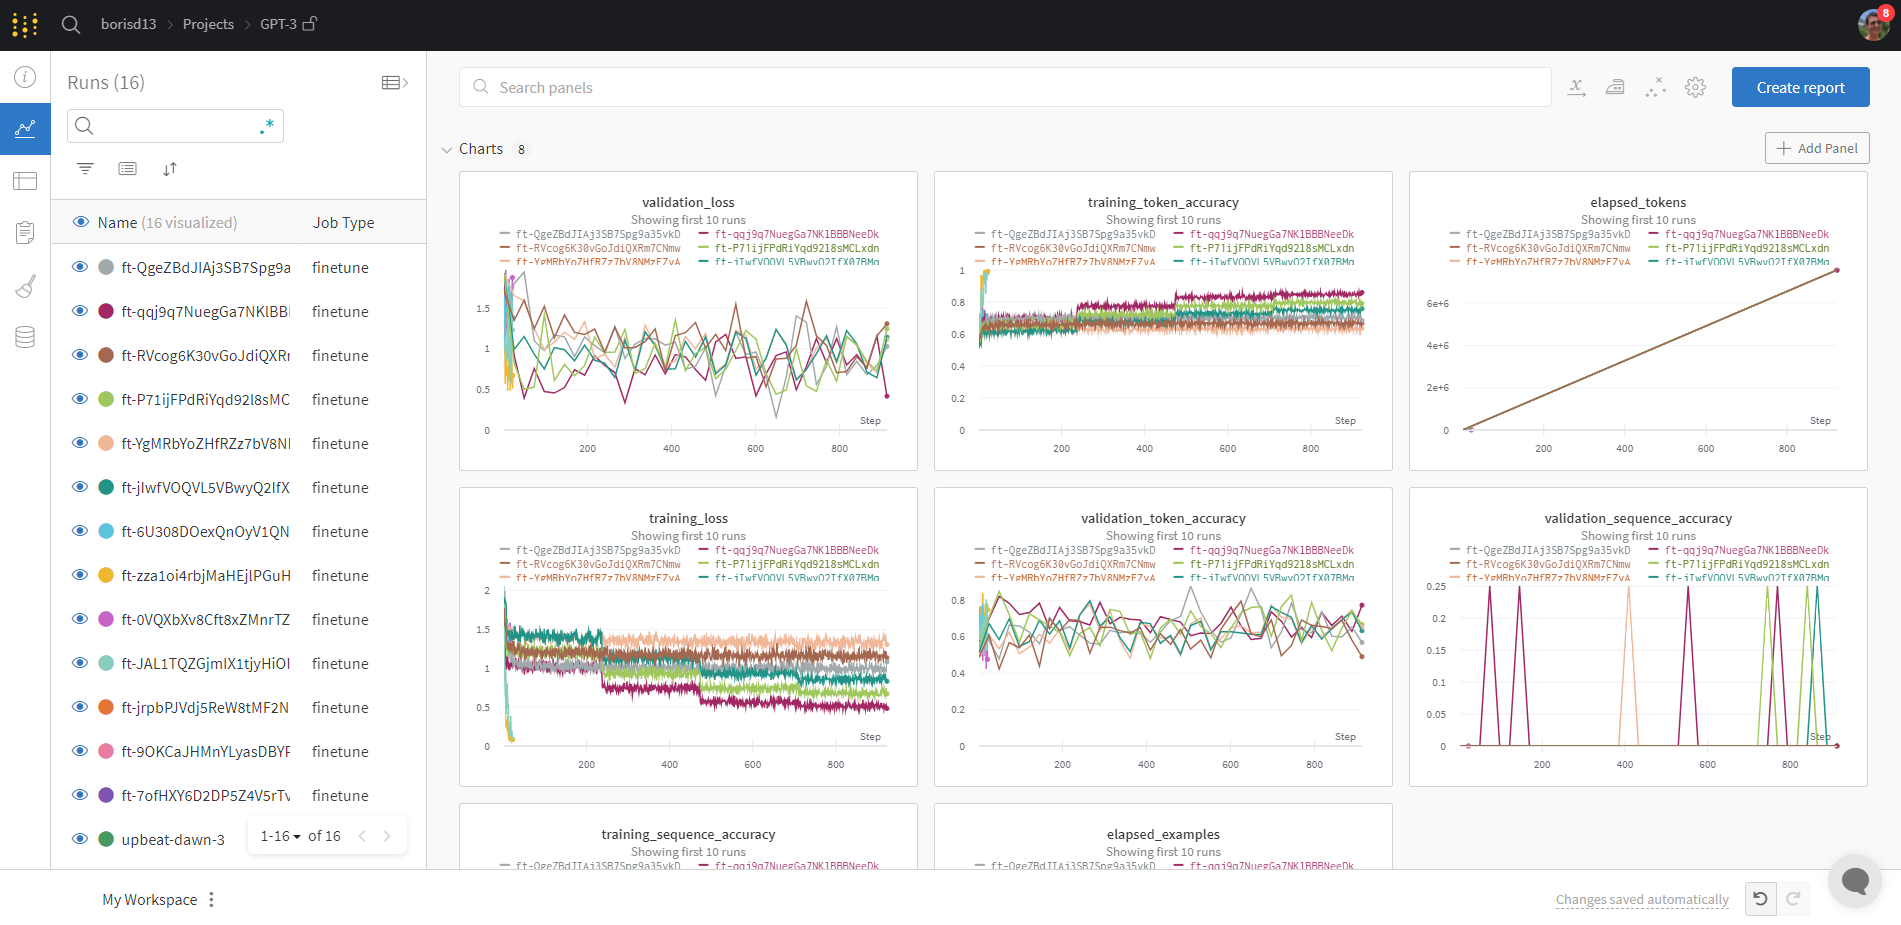

Anytime we have new fine-tunes, we can just call `openai wandb sync` to add them to our dashboard.

## Log inference samples

The best way to evaluate a generative model is to explore sample predictions.

Let's generate a few inference samples and log them to W&B.

In [ ]:
# create eval job
run = wandb.init(project='GPT-3', job_type='eval')

We can easily retrieve all config parameters from a job file.

Job files are logged to W&B as artifacts and can be accessed with `run.use_artifact('USERNAME/PROJECT/job_details:VERSION')` where `VERSION` is either:
* a version number such as `v2`
* the fine-tune id such as `ft-xxxxxxxxx`
* an alias added automatically such as `latest` or manually

You can explore them in your artifacts dashboard.

In [ ]:
# choose a fine-tuned model
artifact_job = run.use_artifact(f'{entity}/GPT-3/fine_tune:latest')

All the details of the job are present in its metadata.

In [ ]:
artifact_job.metadata

Let's take advantage to add metadata into our eval run config.

In [ ]:
wandb.config.update({k:artifact_job.metadata[k] for k in ['fine_tuned_model', 'model', 'hyperparams']})

We can easily access model id from any job.

In [ ]:
fine_tuned_model = artifact_job.metadata['fine_tuned_model']
fine_tuned_model

Let's now retrive our latest validation file and extract a few samples from it

In [ ]:
artifact_valid = run.use_artifact(f'{entity}/GPT-3/valid-wiki_valid.jsonl:latest')
valid_file = artifact_valid.get_path('wiki_valid.jsonl').download()
valid_file

In [ ]:
df = pd.read_json(valid_file, orient='records', lines=True)
df

We'll perform the inference only on a few examples.

In [ ]:
n_samples = 100
df = df.iloc[:n_samples]

In [ ]:
data = []

for _, row in tqdm(df.iterrows()):
    prompt = row['prompt']
    res = openai.Completion.create(model=fine_tuned_model, prompt=prompt, max_tokens=100, stop=[" END"])
    completion = res['choices'][0]['text']
    completion = completion[1:]       # remove initial space
    prompt = prompt[:-7]              # remove "\n\n###\n\n"
    target = row['completion'][1:-4]  # remove initial space and "END"
    data.append([prompt, target, completion])

We create and log a W&B Table to easily explore, query & compare model predictions.

In [ ]:
prediction_table = wandb.Table(columns=['prompt', 'target', 'completion'], data=data)

In [ ]:
wandb.log({'predictions': prediction_table})

We can also log predictions on celebrities.

In [ ]:
# list of famous people
celebrities = ['Joe Biden',
               'Elon Musk',
               'Lady Gaga',
               'Yann Lecun',
               'Andrej Karpathy',
               'Greg Brockman',
               'Ilya Sutskever',
               'Sam Altman',
               'Peter Welinder',
               'Rick and Morty',
               'Lukas Biewald',
               'Chris van Pelt',
               'Shawn Lewis',
               'Naval',
               'Roy E. Bahat',
               'Pete Skomoroch',
               'James Cham',
               'Daniel Gross',
               'Zinedine Zidane',
               'Boris Dayma']

# reformat prompt
celebrities = [f'{x}\n\n###\n\n' for x in celebrities]

In [ ]:
data = []

for prompt in tqdm(celebrities):
    res = openai.Completion.create(model=fine_tuned_model, prompt=prompt, max_tokens=100, stop=[" END"])
    completion = res['choices'][0]['text']
    completion = completion[1:]       # remove initial space
    prompt = prompt[:-7]              # remove "\n\n###\n\n"
    data.append([prompt, completion])

In [ ]:
prediction_table = wandb.Table(columns=['prompt', 'completion'], data=data)

In [ ]:
wandb.log({'celebrities': prediction_table})

In [ ]:
wandb.finish()

# Resources

* [OpenAI Fine-Tuning Guide](https://beta.openai.com/docs/guides/fine-tuning)
* [W&B Integration with OpenAI API](https://wandb.me/openai-docs)
* [W&B Report: GPT-3 exploration & fine-tuning tips](http://wandb.me/openai-report)